# Load the necessary packages

In [2]:
# Import libraries:
import numpy as np
import cv2
import pandas as pd
from skimage.io import imread
import skimage.io as ski
import os
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
# from patchify import patchify
import tifffile as tiff
from pathlib import Path

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from PIL import Image


from Training_lib import Load_training_data, Split_data, Load_and_prepare_data, Main_model
from Prediction_lib import Large_pred
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize, to_categorical
import timeit
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import timeit
from Patches_lib import generate_patches
import math

2025-04-29 14:41:02.105236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 14:41:02.287776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 14:41:02.435637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 14:41:02.480915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 14:41:02.658846: I tensorflow/core/platform/cpu_feature_guar

# Use GPU

### Memory Usage Limitation During Training

To ensure fair usage of shared resources on the cluster, it's important to **limit the amount of memory (in GB) used during training**.

Doing so prevents the training process from occupying all available memory, which could negatively impact other users working on the same cluster.

<div class="alert alert-block alert-danger">
<b>Consider setting memory constraints explicitly in your code or job configuration to avoid monopolizing system resources.<b>
</div>


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

Gb_of_RAM = 10

tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*Gb_of_RAM)])


logical_gpus = tf.config.list_logical_devices('GPU')
print("Using", Gb_of_RAM, "Gb of RAM from ", len(gpus) ,"Physical GPU")

2025-04-29 14:41:07.852793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Num GPUs Available:  1
Using 10 Gb of RAM from  1 Physical GPU


# Load model and Preform segmentation on Large Images

## Direct prediction

Prediction is performed directly using the trained U-Net model. The large image is then reconstructed using a sliding window approach to smooth patch borders and reduce misclassifications caused by edge effects.

- `Patch_size`  
  This defines the size (in pixels) of square patches that the input images are divided into.  
  For example, if `Patch_size` is $256$, each image will be processed in blocks of $256 \times 256$ pixels.  
  This is commonly used in patch-based training for deep learning models, particularly in image segmentation tasks.

- `n_classes`  
  This indicates the total number of classes to be predicted in the image.  

In [4]:
Patch_size = 256
Data_folder = 'Data'
n_classes = 4
Training_param = False

# Model name and emplacement:
Save_name      = 'UNet_' + str(Patch_size) + 'px_v1'
model_folder   = 'Saved_models/'
history_folder = 'Saved_history/'

if not os.path.exists(model_folder) and not os.path.exists(history_folder):
    os.mkdir(model_folder)
    os.mkdir(history_folder)
    print("Model and history directories created")
else:
    print("The model and history directories already exist.")

# Training/Loading:
start = timeit.default_timer()

model, history = Main_model(Save_name=Save_name, model_folder=model_folder, history_folder=history_folder, 
                            n_classes= n_classes, Patch_size = Patch_size,
                            Training_param = Training_param)

stop = timeit.default_timer()
total_time = stop - start

if Training_param:
    print(f"Total training time is = {np.floor(total_time/60):.0f}:%02d" % (total_time - np.floor(total_time / 60) * 60), "min")
else: 
    print(f"Total loading time is = {np.floor(total_time/60):.0f}:%02d" % (total_time - np.floor(total_time / 60) * 60), "min")

The model and history directories already exist.
History loaded successfully
Total loading time is = 0:01 min



<div class="alert alert-block alert-info">
One important parameter in this part of the code is <b>`s`</b>, which represents the <b>stride</b> of the sliding window.
</div>


- `s` is a **positive integer**.
- It defines the number of pixels the window moves at each step.
- It effectively controls how the image is **padded** and how the sliding window **covers** the full image.

Choosing an appropriate stride is crucial to ensure full image coverage and to manage overlaps or gaps between patches.

In [9]:
All_Images_names = sorted(list(Path(Data_folder+'/SEM Image/').glob('*.tif')))
All_Labels_names = sorted(list(Path(Data_folder+'/Labels/').glob('*.tif')))

def calculate_accuracy(gt, pred):
    """Calculate the pixel accuracy between ground truth and prediction."""
    correct = np.sum(gt == pred)
    total = gt.size
    return correct / total

vec = [256,32]
for II in range(7):
    for s in vec:
        Image_name = All_Images_names[II]
        Label_name = All_Labels_names[II]
        
        Probability_map, Final_prediction = Large_pred(Image_name, Label_name, model, Patch_size, stride=s, Norm=True, tech=None)

        target = ski.imread(Label_name)
        target = target[0:Final_prediction.shape[0], 0:Final_prediction.shape[1]]/85
        accuracy = calculate_accuracy(target, Final_prediction)
        accuracy_percent = accuracy*100  # Convert to percentage
        print(accuracy_percent)
        
        # Save results
        Res_folder = Data_folder+'/Model_prediction/'
        if not os.path.exists(Res_folder):
            os.mkdir(Res_folder)
            print("Results directory created")
        else:
            print("Results directory already exist.")
        
        tiff.imwrite(Res_folder+f'Image_{II}_prediction_{s}.tif', Final_prediction.astype(np.uint8))

Processing image : Data/SEM Image/Image_0.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:06 min
92.9597334428267
Results directory already exist.
Processing image : Data/SEM Image/Image_0.tif
Iteration 1 out of 64
Iteration 2 out of 64
Iteration 3 out of 64
Iteration 4 out of 64
Iteration 5 out of 64
Iteration 6 out of 64
Iteration 7 out of 64
Iteration 8 out of 64
Iteration 9 out of 64
Iteration 10 out of 64
Iteration 11 out of 64
Iteration 12 out of 64
Iteration 13 out of 64
Iteration 14 out of 64
Iteration 15 out of 64
Iteration 16 out of 64
Iteration 17 out of 64
Iteration 18 out of 64
Iteration 19 out of 64
Iteration 20 out of 64
Iteration 21 out of 64
Iteration 22 out of 64
Iteration 23 out of 64
Iteration 24 out of 64
Iteration 25 out of 64
Iteration 26 out of 64
Iteration 27 out of 64
Iteration 28 out of 64
Iteration 29 out of 64
Iteration 30 out of 64
Iteration 31 out of 64
Iteration 32 out of 64
Iteration 33 out of 64
Iteration 34 out of 64
Iteration 35

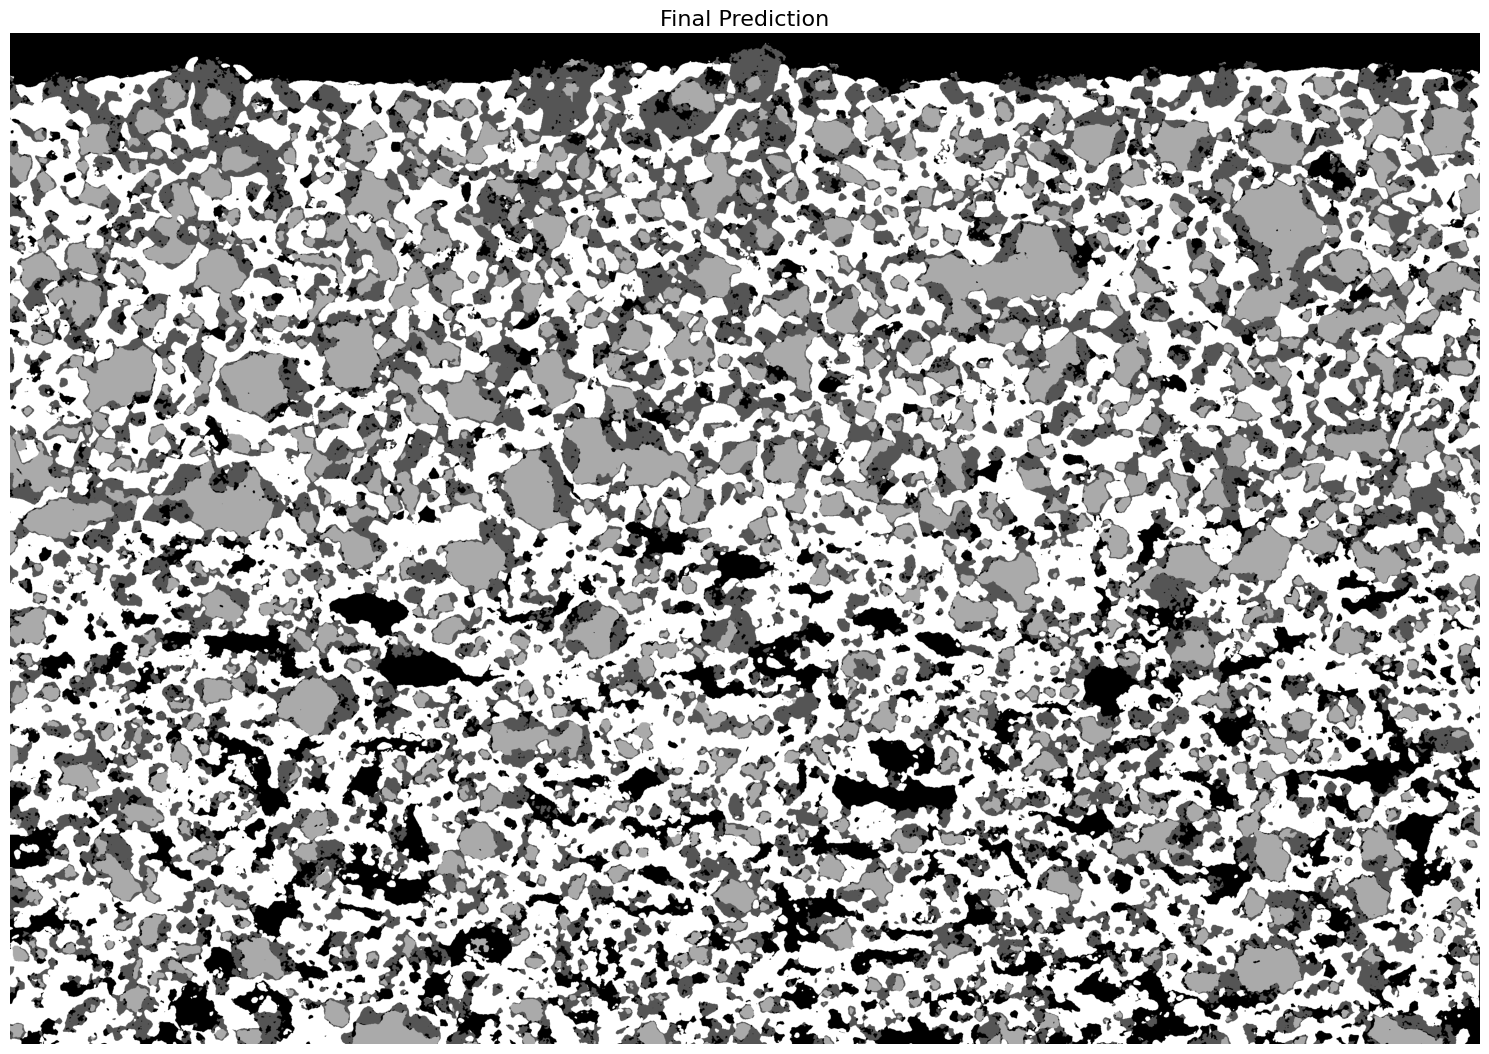

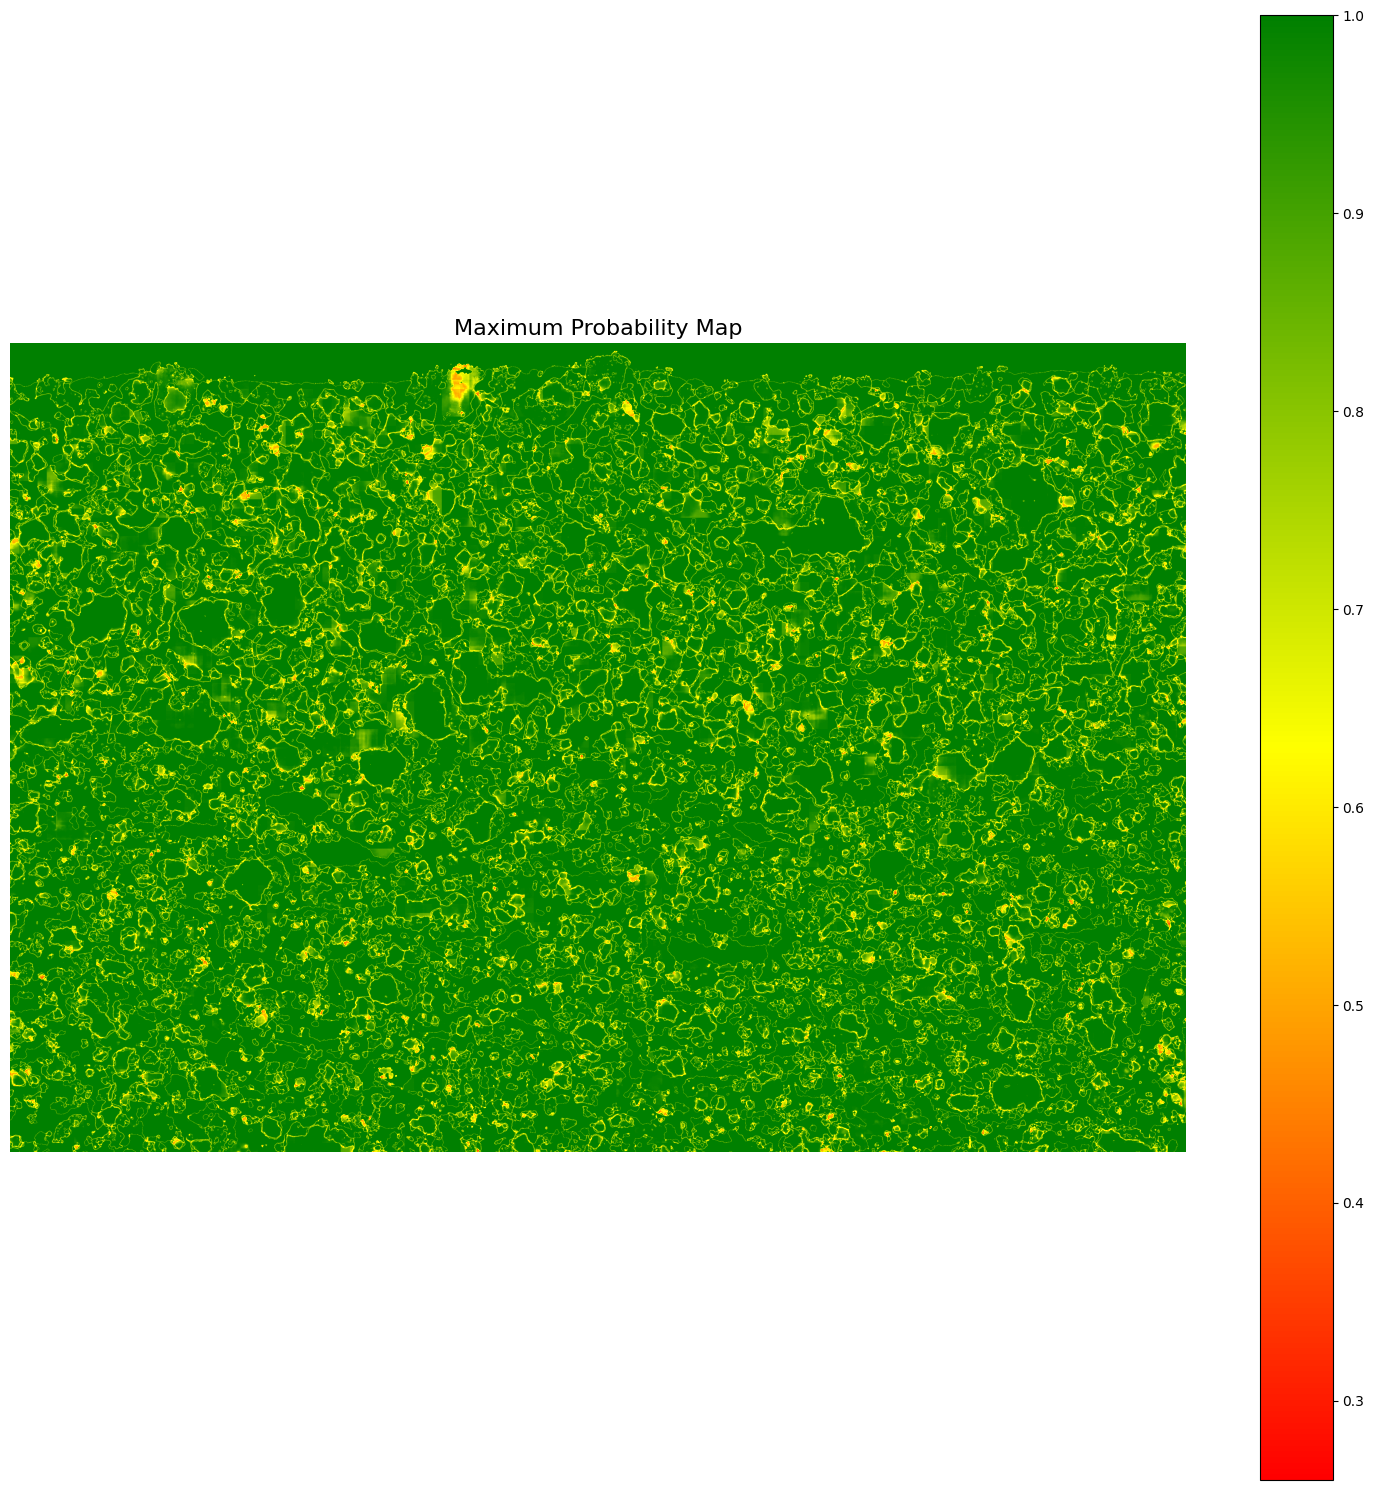

In [10]:
# Display final prediction (binary or categorical mask)
plt.figure(figsize=(15, 15))
plt.imshow(Final_prediction, cmap='gray')
plt.title("Final Prediction", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Display max probability map with colorbar
plt.figure(figsize=(15, 15))
prob_map = np.max(Probability_map, axis=-1)
cmap = plt.cm.RdYlGn
red_yellow_green_cmap = LinearSegmentedColormap.from_list("RedYellowGreen", ["red", "yellow", "green"])
im = plt.imshow(prob_map, cmap=red_yellow_green_cmap)
plt.title("Maximum Probability Map", fontsize=16)
plt.colorbar(im)#, fraction=0.046, pad=0.04)
plt.axis('off')
plt.tight_layout()
plt.show()

## Ensemble prediction

<div class="alert alert-block alert-info">
<b>For info:</b> This technique can be more time-consuming, as multiple models are loaded at each iteration of the sliding window. However, it can yield better generalization and improved prediction results.
</div>

In [11]:
Patch_size = 256
Data_folder = 'Data'
n_classes = 4
Training_param = False

All_Images_names = sorted(list(Path(Data_folder+'/SEM Image/').glob('*.tif')))
All_Labels_names = sorted(list(Path(Data_folder+'/Labels/').glob('*.tif')))

II = 2
s = 128

Image_name = All_Images_names[II]
Label_name = All_Labels_names[II]

Probability_map_ens, Final_prediction_ens = Large_pred(Image_name, Label_name, Patch_size=Patch_size, stride=s, Norm=True, tech='Ensemble')

# Save results
Res_folder = Data_folder+'/Model_prediction/'
if not os.path.exists(Res_folder):
    os.mkdir(Res_folder)
    print("Results directory created")
else:
    print("Results directory already exist.")

tiff.imwrite(Res_folder+f'Image_{II}_prediction_{s}.tif', Final_prediction.astype(np.uint8))

Processing image : Data/SEM Image/Image_2.tif
Iteration 1 out of 4
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
Iteration 2 out of 4
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
Iteration 3 out of 4
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
History loaded successfully
Iteration 4 out of 4
History loaded successfully
Hi

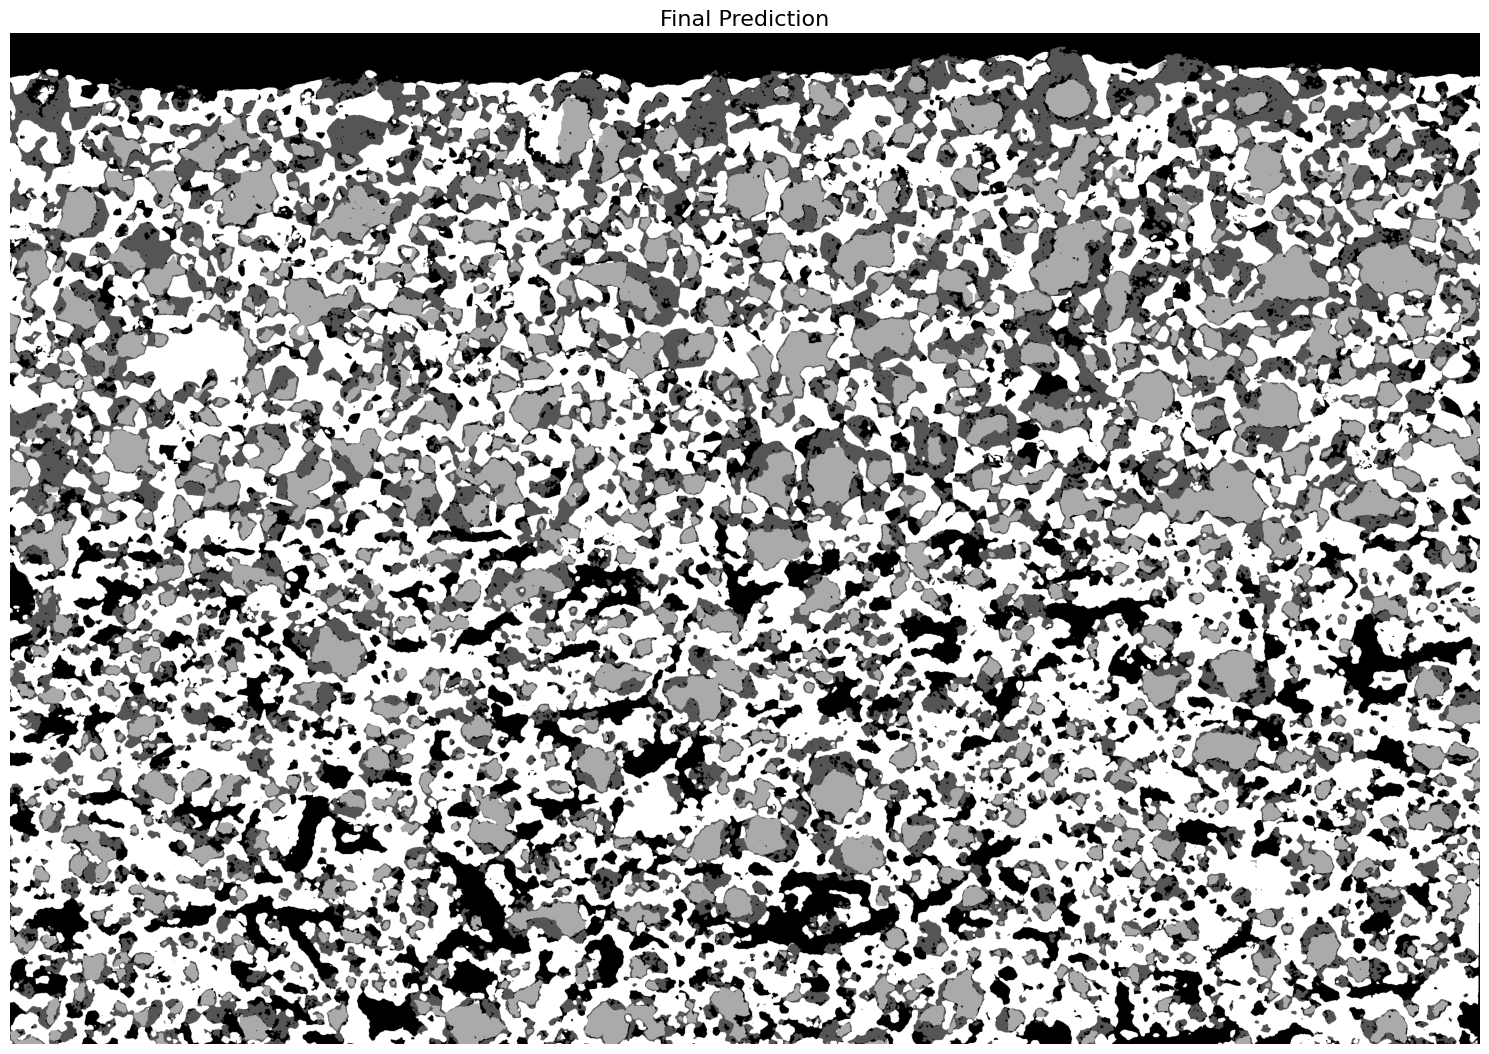

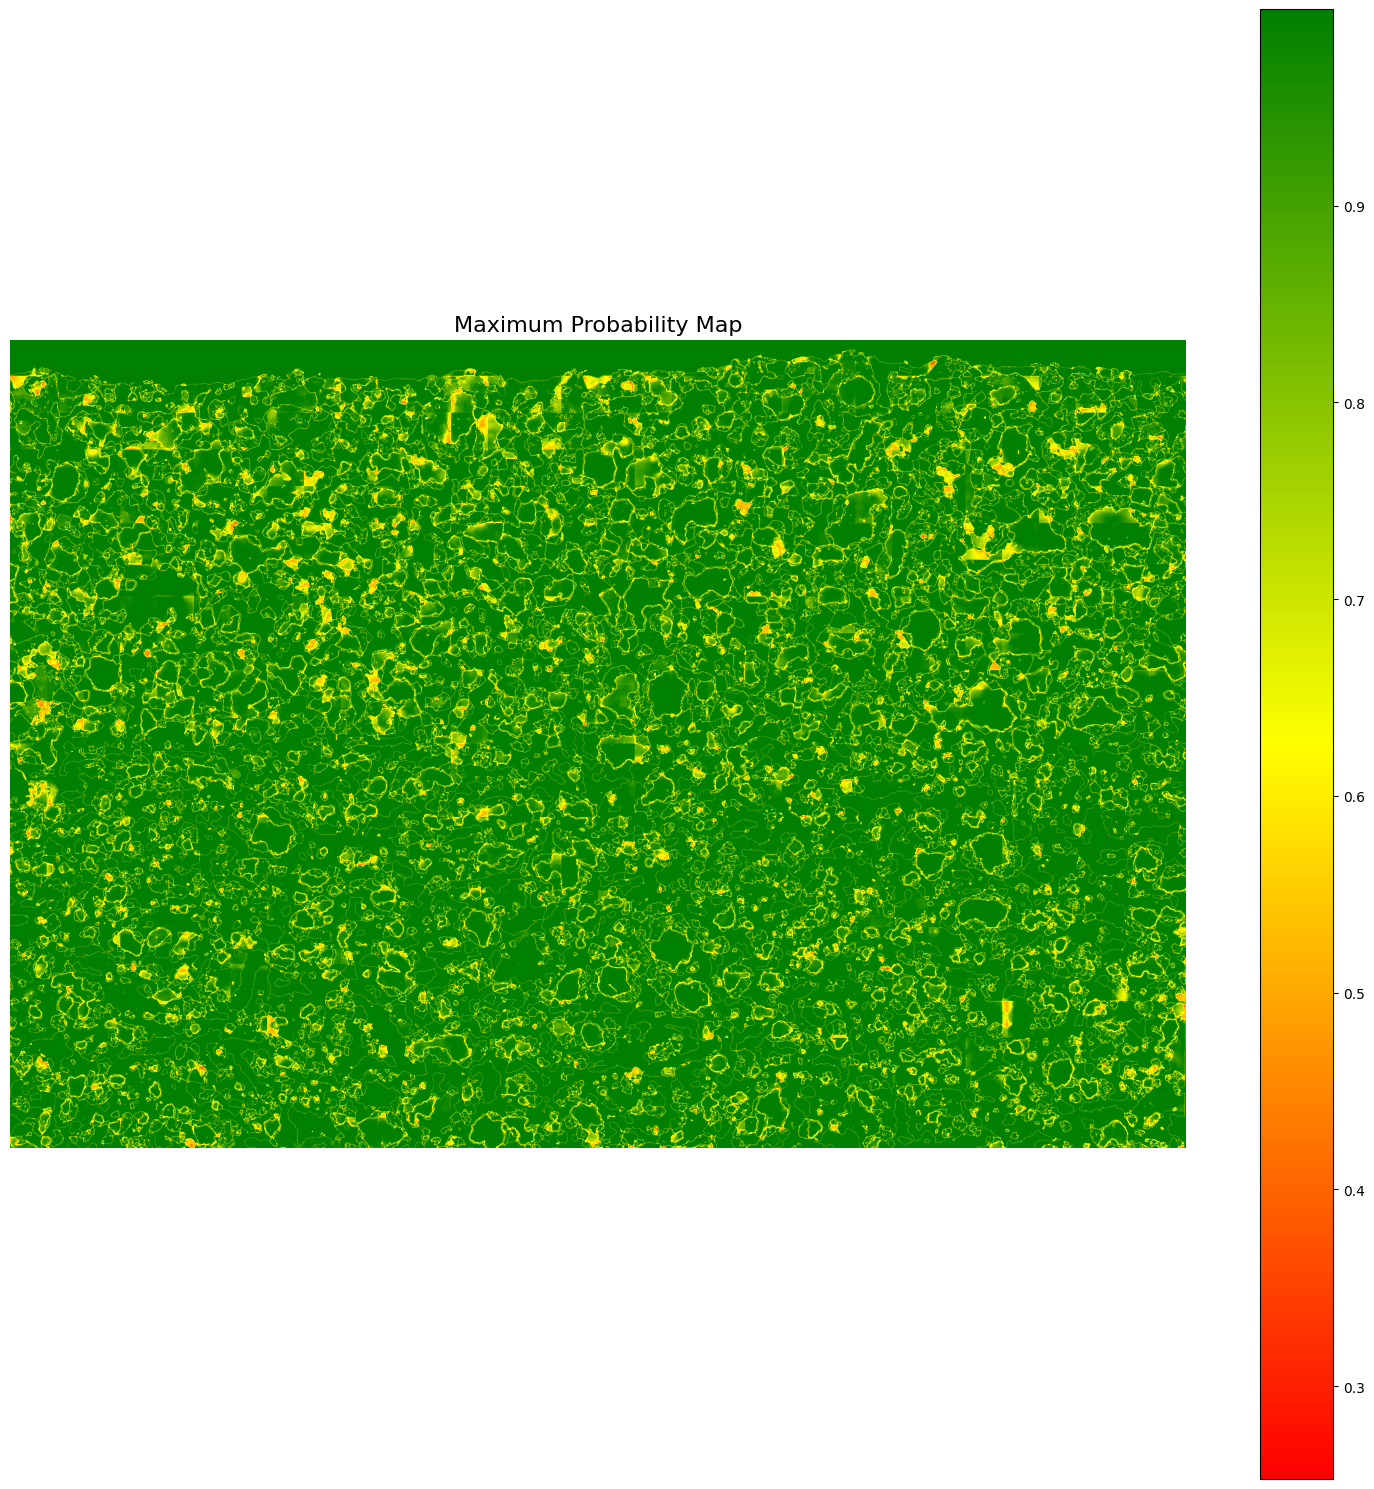

In [12]:
# Display final prediction (binary or categorical mask)
plt.figure(figsize=(15, 15))
plt.imshow(Final_prediction_ens, cmap='gray')
plt.title("Final Prediction", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Display max probability map with colorbar
plt.figure(figsize=(15, 15))
prob_map = np.max(Probability_map_ens, axis=-1)
cmap = plt.cm.RdYlGn
red_yellow_green_cmap = LinearSegmentedColormap.from_list("RedYellowGreen", ["red", "yellow", "green"])
im = plt.imshow(prob_map, cmap=red_yellow_green_cmap)
plt.title("Maximum Probability Map", fontsize=16)
plt.colorbar(im)#, fraction=0.046, pad=0.04)
plt.axis('off')
plt.tight_layout()
plt.show()